In [1]:
import numpy as np
import scipy 
from sympy import *
import pylab as plt
import math
from sympy.physics.wigner import gaunt
from scipy.integrate import odeint
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
BohrRad = 0.529177e-10 #Bohr Radii to Meters
Dalton = 1.66053906892e-27 #Dalton to kg
Dalton_eV = 931.49410372*1e6 
GGHz2H = 1.519829846e-7 #Gigahertz to Hartrees
J2invB = 2.29e18
Tesla2invB = 2.293712e17

me=9.1093837e-31
mH=1.00784*Dalton
mT=3.01604928178*Dalton
mH_in_eV = 1.00784 * Dalton_eV #Mass of hydrogen in eV
mT_in_eV = 3.01604928178 * Dalton_eV #Mass of tritium in eV
muoveH=mH/(2*me) #mass is unitless in atomic units because we let me = 1 H stands for Hydrogen 
muoveT=mT/(2*me) #T stands for tritium

mue = 9.2740100657e-24 #Magnetic moment of the electron J/T
muT = mue * me / mT #Nuclear magnetic moment
muH = mue * me / mH

l = 0 #this is explicitly required for properly defining our in state at infinity
l_prime = 2 #all allowed transitions require even l transitions, these are confirmed with Winger 3J symbols from the spherical nature
#of the distored wave Born approximation

In [3]:
#Getting the hyperfine and zeeman level energy contributions to the total energy
HyperFine=21e-2
c=3e8
delW=c/HyperFine

gI=5.585
ge=2
gL=1
gS=2
mue=9.27e-24
mN=1e9

B_values=np.linspace(1e-5,.1,30)

def PlotHyperfineLevels(pm,mF,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02):
    h=6.6e-34
    S=0.5
    mue=9.27e-24
    me=5.11e5
    muN=mue*me/(1e9*mN)

    gJ=gL*(J*(J+1)+L*(L+1)-S*(S+1))/(2*J*(J+1))  +ge*(J*(J+1)-L*(L+1)+S*(S+1))/(2*J*(J+1))
    
    x=B*(gJ*mue-gI*muN)/(h *delW)
    Term1=-h*delW/(2*(2*I+1))*np.ones_like(B)
    Term2=muN*gI*mF*B
    if(abs(mF)==abs(I+0.5)):
        sgn=mF/(I+0.5)
        Term3=h*delW/2*(1+sgn*x)
    else:    
        Term3=pm*h*delW/2*np.sqrt(1+2*mF*x/(I+0.5)+x**2)

    delE=1e-9*(Term1+Term2+Term3)/h
    
    return delE
#it is important to note that this code uses B field in tesla and the representing hyperfine energies are in units of gigahertz

In [4]:
#Defining the schodinger equation such that the hyperfine and zeeman contributions get absorbed into our p values 
def Potential(R): #Silvera Potential Energy Units are in Hartrees
    x=R*BohrRad/4.16e-10
    D=1.28
    KToH=315775
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46/KToH*(4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)
    
def Triplet(R):
    return np.exp(0.09678-1.10173*R-0.03945*R**2)+np.exp(-(10.04/R-1)**2)*(-6.5/R**6-124/R**8-3285/R**10)
    
def ddxH1(y,rho, l, p): #SE for Hydrogen now represented as two first order ODEs
    u=y[0]
    v=y[1]
    dudx=v
    dvdx=(-p**2+2*muoveH*Potential(rho) + l*(l+1)/(rho**2))*u
    return [dudx,dvdx]
    
def ddxT1(y,rho, l, p):
    u=y[0]
    v=y[1]
    dudx=v
    dvdx=(-p**2+2*muoveT*Potential(rho) + l*(l+1)/(rho**2))*u
    return [dudx,dvdx]

def ddxH2(y,rho, l, p): #SE for Hydrogen now represented as two first order ODEs
    u=y[0]
    v=y[1]
    dudx=v
    dvdx=(-p**2+2*muoveH*Triplet(rho) + l*(l+1)/(rho**2))*u
    return [dudx,dvdx]
    
def ddxT2(y,rho, l, p):
    u=y[0]
    v=y[1]
    dudx=v
    dvdx=(-p**2+2*muoveT*Triplet(rho) + l*(l+1)/(rho**2))*u
    return [dudx,dvdx]

In [5]:
#Getting the incoming momentum as a function of temperature because we want to compare the trap loss rates at 
#the same temperature not the absolute momentum
def p_of_temp(m, T, kb = 3.166811563e-6):
    return (2*m*kb*T)**.5
    

#defining the outgoing momentum as a function of incoming momentum. Or how the transfer of energy between the central potentials behaves
def pprime_of_p(p,ea,eb,eap,ebp,m):
    mu = m/2
    E = p**2/(2*mu)
    Eprime = E + ea + eb - eap - ebp
    pprime = np.sqrt(2*mu*Eprime) 
    return pprime

In [6]:
def Central_State(PToInt, lToInt, L, r0, function):
    def ddxToint(rho,y):
        return function(y, rho, lToInt, PToInt)
    rhos = np.linspace(r0,L, 100000)

    Init=[r0,1]
    State = scipy.integrate.solve_ivp(ddxToint,[rhos[0],rhos[-1]],Init,t_eval=rhos,method='RK23')
    Normalization = (State.y[0]**2+(1/PToInt*State.y[1])**2)**.5
    return [rhos,State.y[0]/(Normalization[-1])]

In [7]:
GHaa1_Elements=[]
GTaa1_Elements=[]
GHac1_Elements=[]
GTac1_Elements=[]
GHad1_Elements=[]
GTad1_Elements=[]
for B in B_values:
    epsa = GGHz2H*PlotHyperfineLevels(0,0,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) #Following Stoofs notation these 
    epsb = GGHz2H*PlotHyperfineLevels(1,-1,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) # are the channel specific energies
    epsc = GGHz2H*PlotHyperfineLevels(1,0,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) # in order of lowest energy to highest
    epsd = GGHz2H*PlotHyperfineLevels(1,1,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) #we need to convert the hyperfine energies
    for i in [0,1,2]:
        epsalpha = epsd #Following Stoofs notation again, alpha and beta are the associated in states and the primes from here on will
        epsbeta = epsd #be used to designate the time reversed out states post interaction. We select specific ones that Stoof claims to be 
        epsalpha_prime = epsa # the dominating terms in the important inelastic trap loss rates

        if i == 0:
            epsbeta_prime = epsa
        elif i == 1:
            epsbeta_prime = epsc
        elif i == 2:
            epsbeta_prime = epsd

        r0 = .1
        temp = .0001
        L=2000
        
        P1H = p_of_temp(muoveH, temp, kb = 3.166811563e-6)
        P1T = p_of_temp(muoveT, temp, kb = 3.166811563e-6)
        P2H = pprime_of_p(P1H,epsalpha,epsbeta,epsalpha_prime,epsbeta_prime,muoveH)
        P2T = pprime_of_p(P1T,epsalpha,epsbeta,epsalpha_prime,epsbeta_prime,muoveT)

        def GetIntegrals(epsalpha,epsbeta,epsalpha_prime,epsbeta_prime,L,r0,temps):
    
            IntegralsH=[]
            IntegralsT=[]
    
            for temp in temps:  
                rhos, TState1=Central_State(PToInt=P1T,lToInt=0,L=L,r0=r0,function=ddxT1)
                rhos, TState2=Central_State(PToInt=P2T,lToInt=2,L=L,r0=r0,function=ddxT1)
                TIntegrand=interp1d(rhos,np.real(TState1*TState2/(rhos**3)),kind='quadratic')
                IntegralsT.append(quad(TIntegrand,rhos[0],rhos[-1])[0]/(P1T*P2T))

                rhos, HState1=Central_State(PToInt=P1H,lToInt=0,L=L,r0=r0,function=ddxH1)
                rhos, HState2=Central_State(PToInt=P2H,lToInt=2,L=L,r0=r0,function=ddxH1)
                HIntegrand=interp1d(rhos,np.real(HState1*HState2/(rhos**3)),kind='quadratic')
                IntegralsH.append(quad(HIntegrand,rhos[0],rhos[-1])[0]/(P1H*P2H))
            return(IntegralsT, IntegralsH)

        IntegralsT,IntegralsH = GetIntegrals (epsalpha,epsbeta,epsalpha_prime,epsbeta_prime,L,r0,[temp])

        TSpatial = 4 * np.pi**3 * Tesla2invB * muoveT * P2T * (Tesla2invB * mue / (4*np.pi) * (4*np.pi/5)**.5 * (Tesla2invB * mue) * IntegralsT[0])**2
        HSpatial = 4 * np.pi**3 * Tesla2invB * muoveH * P2H * (Tesla2invB * mue / (4*np.pi) * (4*np.pi/5)**.5 * (Tesla2invB * mue) * IntegralsH[0])**2

        if i == 0:
            GHaa1_Elements.append(HSpatial)
            GTaa1_Elements.append(TSpatial)
        elif i == 1:
            GHac1_Elements.append(HSpatial)
            GTac1_Elements.append(TSpatial)
        elif i == 2:
            GHad1_Elements.append(HSpatial)
            GTad1_Elements.append(TSpatial)
GHaa1_Elements = np.array(GHaa1_Elements)
GTaa1_Elements = np.array(GTaa1_Elements)
GHac1_Elements = np.array(GHac1_Elements)
GTac1_Elements = np.array(GTac1_Elements)
GHad1_Elements = np.array(GHad1_Elements)
GTad1_Elements = np.array(GTad1_Elements)


In [8]:
GHaa2_Elements=[]
GTaa2_Elements=[]
GHac2_Elements=[]
GTac2_Elements=[]
GHad2_Elements=[]
GTad2_Elements=[]
for B in B_values:
    epsa = GGHz2H*PlotHyperfineLevels(0,0,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) #Following Stoofs notation these 
    epsb = GGHz2H*PlotHyperfineLevels(1,-1,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) # are the channel specific energies
    epsc = GGHz2H*PlotHyperfineLevels(1,0,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) # in order of lowest energy to highest
    epsd = GGHz2H*PlotHyperfineLevels(1,1,B,delW=1.428e9,I=0.5,L=0,J=0.5,mN=1,gI=5.585,ge=2.02) #we need to convert the hyperfine energies
    for i in [0,1,2]:
        epsalpha = epsd #Following Stoofs notation again, alpha and beta are the associated in states and the primes from here on will
        epsbeta = epsd #be used to designate the time reversed out states post interaction. We select specific ones that Stoof claims to be 
        epsalpha_prime = epsa # the dominating terms in the important inelastic trap loss rates

        if i == 0:
            epsbeta_prime = epsa
        elif i == 1:
            epsbeta_prime = epsc
        elif i == 2:
            epsbeta_prime = epsd

        r0 = .1
        temp = .001
        L=2000
        
        P1H = p_of_temp(muoveH, temp, kb = 3.166811563e-6)
        P1T = p_of_temp(muoveT, temp, kb = 3.166811563e-6)
        P2H = pprime_of_p(P1H,epsalpha,epsbeta,epsalpha_prime,epsbeta_prime,muoveH)
        P2T = pprime_of_p(P1T,epsalpha,epsbeta,epsalpha_prime,epsbeta_prime,muoveT)

        def GetIntegrals(epsalpha,epsbeta,epsalpha_prime,epsbeta_prime,L,r0,temps):
    
            IntegralsH=[]
            IntegralsT=[]
    
            for temp in temps:  
                P1T = p_of_temp(muoveT, temp, kb = 3.166811563e-6)
                P2T = pprime_of_p(P1T,epsalpha,epsbeta,epsalpha_prime,epsbeta_prime,muoveT)
                rhos, TState1=Central_State(PToInt=P1T,lToInt=0,L=L,r0=r0,function=ddxT2)
                rhos, TState2=Central_State(PToInt=P2T,lToInt=2,L=L,r0=r0,function=ddxT2)
                TIntegrand=interp1d(rhos,np.real(TState1*TState2/(rhos**3)),kind='quadratic')
                IntegralsT.append(quad(TIntegrand,rhos[0],rhos[-1])[0]/(P1T*P2T))

                P1H = p_of_temp(muoveH, temp, kb = 3.166811563e-6)
                P2H = pprime_of_p(P1H,epsalpha,epsbeta,epsalpha_prime,epsbeta_prime,muoveH)
                rhos, HState1=Central_State(PToInt=P1H,lToInt=0,L=L,r0=r0,function=ddxH2)
                rhos, HState2=Central_State(PToInt=P2H,lToInt=2,L=L,r0=r0,function=ddxH2)
                HIntegrand=interp1d(rhos,np.real(HState1*HState2/(rhos**3)),kind='quadratic')
                IntegralsH.append(quad(HIntegrand,rhos[0],rhos[-1])[0]/(P1H*P2H))
            return(IntegralsT, IntegralsH)

        IntegralsT, IntegralsH = GetIntegrals (epsalpha,epsbeta,epsalpha_prime,epsbeta_prime,L,r0,[temp])

        TSpatial = 4 * np.pi**3 * Tesla2invB * muoveT * P2T * (Tesla2invB * mue / (4*np.pi) * (4*np.pi/5)**.5 * (Tesla2invB * mue) * IntegralsT[0])**2
        HSpatial = 4 * np.pi**3 * Tesla2invB * muoveH * P2H * (Tesla2invB * mue / (4*np.pi) * (4*np.pi/5)**.5 * (Tesla2invB * mue) * IntegralsH[0])**2

        if i == 0:
            GHaa2_Elements.append(HSpatial)
            GTaa2_Elements.append(TSpatial)
        elif i == 1:
            GHac2_Elements.append(HSpatial)
            GTac2_Elements.append(TSpatial)
        elif i == 2:
            GHad2_Elements.append(HSpatial)
            GTad2_Elements.append(TSpatial)
GHaa2_Elements = np.array(GHaa2_Elements)
GTaa2_Elements = np.array(GTaa2_Elements)
GHac2_Elements = np.array(GHac2_Elements)
GTac2_Elements = np.array(GTac2_Elements)
GHad2_Elements = np.array(GHad2_Elements)
GTad2_Elements = np.array(GTad2_Elements)


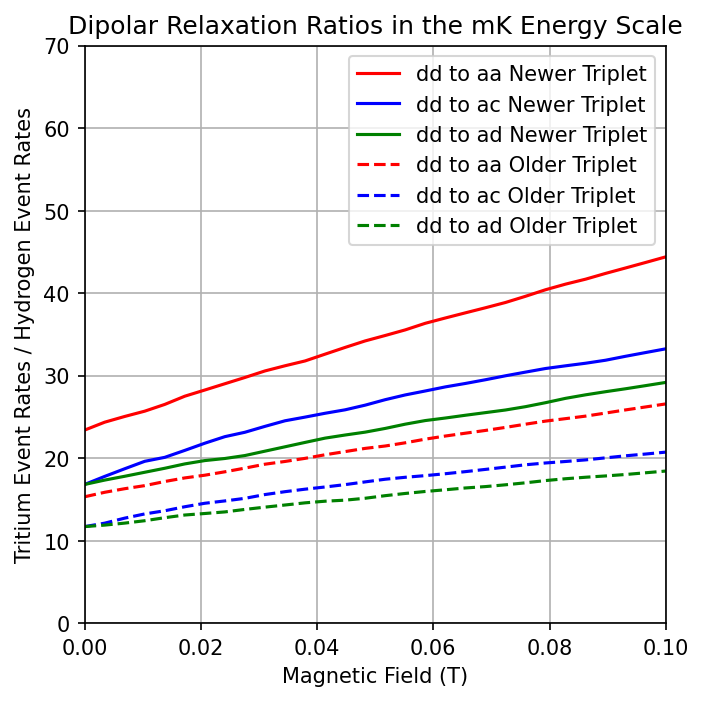

In [9]:
plt.figure(figsize=(5, 5),dpi=150)
plt.plot(B_values,GTaa1_Elements/GHaa1_Elements, label="dd to aa Newer Triplet",color ="red")
plt.plot(B_values,GTac1_Elements/GHac1_Elements,label="dd to ac Newer Triplet",color ="blue")
plt.plot(B_values,GTad1_Elements/GHad1_Elements,label="dd to ad Newer Triplet",color ="green")
plt.plot(B_values,GTaa2_Elements/GHaa2_Elements, label="dd to aa Older Triplet",linestyle='--',color ="red")
plt.plot(B_values,GTac2_Elements/GHac2_Elements,label="dd to ac Older Triplet",linestyle='--',color ="blue")
plt.plot(B_values,GTad2_Elements/GHad2_Elements,label="dd to ad Older Triplet",linestyle='--',color ="green")
plt.xlabel("Magnetic Field (T)")
plt.xlim(0,.1)
plt.ylabel("Tritium Event Rates / Hydrogen Event Rates")
plt.ylim(0,70)
plt.title("Dipolar Relaxation Ratios in the mK Energy Scale")
plt.grid(True)
plt.legend()
plt.show()